In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.svm import SVC
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import UpSampling2D
from sklearn.ensemble import AdaBoostClassifier

In [2]:
X_train = np.load('X_train_total.npy', allow_pickle=True)
X_val = np.load('X_val_total.npy', allow_pickle=True)
y_train = np.load('y_train_total.npy', allow_pickle=True)
y_val = np.load('y_val_total.npy', allow_pickle=True)

In [3]:
with tf.device('/GPU:0'):  # Use GPU for faster training
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), name='pool1'))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.30))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', name='dense1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(8, activation='softmax', name='dense2'))
    model.summary()
    # Compile the CNN model with appropriate loss and optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))

NameError: name 'BatchNormalization' is not defined

In [5]:
model = tf.keras.models.load_model('h5 files/complex_cnn_test_0.7.h5')

In [6]:
# Define a new model that outputs the feature maps of the first convolutional layer
conv1_output = model.get_layer('conv2d_5').output
conv1_model = Model(inputs=model.input, outputs=conv1_output)

# Choose an input image to visualize
img = X_train[3]

# Generate the feature maps for the input image
features = conv1_model.predict(np.expand_dims(img, axis=0))

# Plot the feature maps using subplots
num_maps = features.shape[-1]
fig, axes = plt.subplots(nrows=16, ncols=8, figsize=(8, 16))
for i in range(num_maps):
    row = i // 8
    col = i % 8
    ax = axes[row, col]
    ax.imshow(features[0, :, :, i], cmap='gray')
    ax.set_title('Feature map {}'.format(i+1))
    ax.axis('off')
plt.show()

# Plot the original input image
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(X_train[3], cmap='gray')
ax.set_title('Original image')
ax.axis('off')
plt.show()

NameError: name 'Model' is not defined

NameError: name 'plt' is not defined

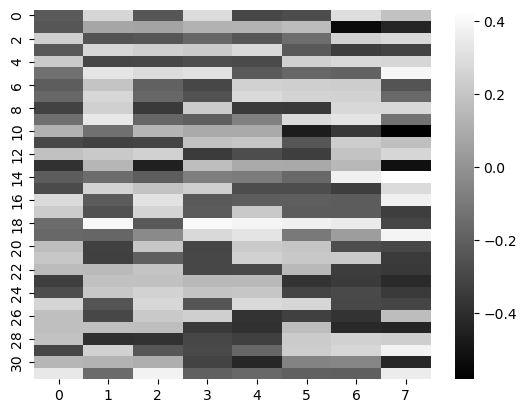

In [7]:
import seaborn as sns

# Extract the weights of the dense layer
dense_weights = model.get_layer('dense2').get_weights()[0]

# Create a heatmap of the weights
sns.heatmap(dense_weights, cmap='gray')
plt.show()

In [8]:
import cv2
import matplotlib.pyplot as plt
cv2.imshow("Input", X_train[3])
cv2.waitKey(0)
print(np.argmax(model.predict(np.expand_dims(X_train[3], axis=0))))
print(y_train[3])

1/1 [==============================] - 5s 5s/step
5
[0. 0. 0. 0. 0. 1. 0. 0.]


In [9]:
print(len(X_val))
pre_list = model.predict(X_val)
wrong_list = []
for i in range(0,len(X_val)):
    if np.argmax(pre_list[i]) != np.argmax(y_val[i]):
        wrong_list.append(i)


6201
194/194 [==============================] - 2s 6ms/step


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_val_multiclass = np.argmax(y_val, axis=1)
# Get the predicted probabilities for the validation set
y_prob = model.predict(X_val)

# Get the predicted labels by finding the class with the highest probability
y_pred = np.argmax(y_prob, axis=1)

# Compute the accuracy score
accuracy = accuracy_score(y_val_multiclass, y_pred)
print('Accuracy:', accuracy)

# Compute the confusion matrix
cm = confusion_matrix(y_val_multiclass, y_pred)
print('Confusion matrix:')
print(cm)

194/194 [==============================] - 1s 5ms/step
Accuracy: 0.7163360748266409
Confusion matrix:
[[769  14  92  14  15  45  10  23]
 [ 23 565  27  63  27  54  29   8]
 [106  24 587  18  15  12   0   6]
 [ 48  96  31 474  24  24  31  34]
 [ 33  58  29  41 406  77  12   9]
 [ 90  34  11   6  33 396  48   6]
 [ 27  37   2  15  17  98 462  46]
 [ 25   5   4  16   4   3  60 783]]


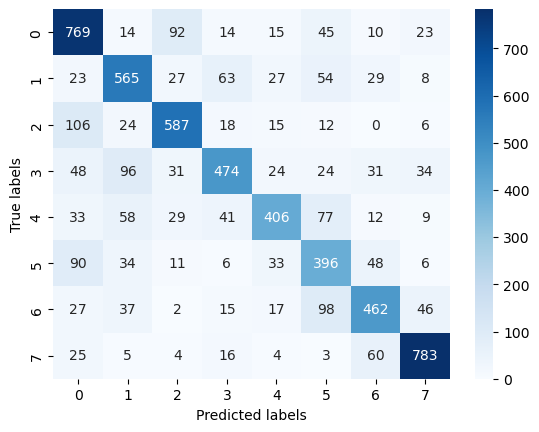

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [12]:
# Remove the final dense layer and dropout layer
model.pop()
model.pop()

# Remove the dense layer with 32 units and the dropout layer before it
model.pop()
model.pop()
model.pop()

# Print the summary of the modified model
model.summary()

train_features = model.predict(X_train)
val_features = model.predict(X_val)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 142, 142, 32)     128       
 ormalization)                                                   
                                                                 
 pool1 (MaxPooling2D)        (None, 71, 71, 32)        0         
                                                                 
 dropout (Dropout)           (None, 71, 71, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 69, 69, 64)       256       
 hNormalization)                                        

In [13]:
train_features = model.predict(X_train)
val_features = model.predict(X_val)
from sklearn.svm import SVC
svm_model = SVC(decision_function_shape='ovo')
svm_model.fit(train_features, y_train)
svm_score = svm_model.score(val_features, y_val)
print(svm_score)

194/194 [==============================] - 1s 5ms/step
0.7171423963876794


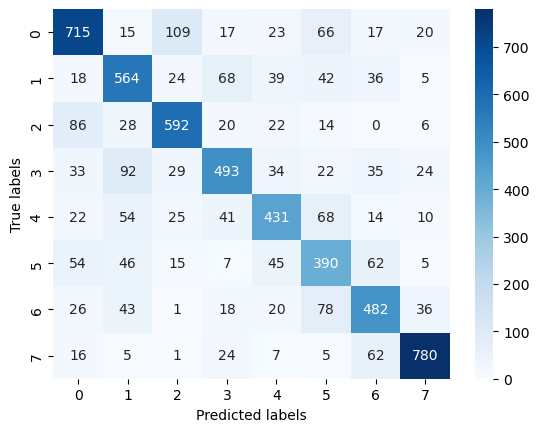

In [14]:
from sklearn.metrics import confusion_matrix

y_pred_svm = svm_model.predict(val_features)

cm_svm = confusion_matrix(y_val, y_pred_svm)

sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1.75,2,1.5],
              'gamma': [1.75,1.5],
              'kernel': ['rbf']}

svm_grid = GridSearchCV(SVC(), param_grid, cv=5)
svm_grid.fit(val_features, y_val)

print('Best parameters:', svm_grid.best_params_)
print('Accuracy:', svm_grid.best_score_)

Best parameters: {'C': 1.5, 'gamma': 1.75, 'kernel': 'rbf'}
Accuracy: 0.7182728548777001


In [17]:
train_features = model.predict(X_train)
val_features = model.predict(X_val)
from sklearn.svm import SVC
svm_model = SVC(C = 10, gamma = 0.1, kernel = 'rbf',decision_function_shape='ovo')
svm_model.fit(train_features, y_train)
svm_score = svm_model.score(val_features, y_val)
print(svm_score)

194/194 [==============================] - 1s 5ms/step
0.716819867763264
